In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import gc
import shutil
import cv2

input_shape = (96, 96, 3)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/

Mounted at /gdrive
/gdrive/My Drive


In [ ]:
data = np.load('Challenge1/Datasets/uniqueDataset.npz', allow_pickle=True)
images, labels = data["images"], data["labels"]
print("Images Shape:", images.shape)
print("Label Shape:", labels.shape)

Images Shape: (11953, 96, 96, 3)
Label Shape: (11953, 1)


In [ ]:
# prompt: mi generi del codicd che prenda in input image e shape mi crei una classe train e validation con 200 immagini per calsse e le elimini dall'input originale

def create_train_val_sets(images, labels, num_images_per_class=125):
  x_test = []
  y_test = []
  x_val = []
  y_val = []
  remaining_images = []
  remaining_labels = []

  unique_labels = np.unique(labels)
  for label in unique_labels:
    class_images = images[labels.flatten() == label]
    class_labels = labels[labels.flatten() == label]

    if len(class_images) >= 2 * num_images_per_class:
      # Split into train and validation sets
      train_images, val_images, train_labels, val_labels = train_test_split(
          class_images, class_labels, test_size=num_images_per_class, random_state=42
      )

      x_test.extend(train_images[:num_images_per_class])
      y_test.extend(train_labels[:num_images_per_class])
      x_val.extend(val_images[:num_images_per_class])
      y_val.extend(val_labels[:num_images_per_class])

      remaining_images.extend(class_images[2 * num_images_per_class:])
      remaining_labels.extend(class_labels[2 * num_images_per_class:])
    else:
      # Not enough images for this class, add all to remaining
      remaining_images.extend(class_images)
      remaining_labels.extend(class_labels)


  x_test = np.array(x_test)
  y_test = np.array(y_test)
  x_val = np.array(x_val)
  y_val = np.array(y_val)
  remaining_images = np.array(remaining_images)
  remaining_labels = np.array(remaining_labels)

  return x_test, y_test, x_val, y_val, remaining_images, remaining_labels

x_test, y_test, x_val, y_val, x_train, y_train = create_train_val_sets(
    images, labels
)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)



x_train shape: (9953, 96, 96, 3)
y_train shape: (9953, 1)
x_test shape: (1000, 96, 96, 3)
y_test shape: (1000, 1)
x_val shape: (1000, 96, 96, 3)
y_val shape: (1000, 1)


In [ ]:
import numpy as np
import tensorflow as tf
import cv2
import os
import random

# Funzione per applicare Grid Mask
def apply_grid_mask(image, d_min=10, d_max=40, ratio=0.6):
    height, width, channels = image.shape
    d = np.random.randint(d_min, d_max)
    mask = np.ones((height, width), dtype=np.float32)

    for i in range(0, height, d):
        for j in range(0, width, d):
            mask[i:int(i + d * ratio), j:int(j + d * ratio)] = 0

    mask = np.tile(mask[..., np.newaxis], [1, 1, channels])
    return (image * mask).astype(np.uint8)

# Funzione per applicare CutMix
def apply_cutmix(images, labels, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    rand_index = np.random.randint(0, len(images))
    mixed_image = lam * images[0] + (1 - lam) * images[rand_index]
    mixed_label = lam * labels[0] + (1 - lam) * labels[rand_index]
    return mixed_image, mixed_label

# Funzione per applicare MixUp
def apply_mixup(images, labels, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    rand_index = np.random.randint(0, len(images))
    mixed_image = lam * images[0] + (1 - lam) * images[rand_index]
    mixed_label = lam * labels[0] + (1 - lam) * labels[rand_index]
    return mixed_image, mixed_label


def apply_cutout(image, max_mask_size=20):
    height, width, channels = image.shape

    # Calcola la dimensione casuale del quadrato
    mask_size = np.random.randint(1, max_mask_size)

    # Se la dimensione del quadrato è troppo grande, limitiamo le dimensioni alla dimensione dell'immagine
    mask_size = min(mask_size, height, width)

    # Seleziona una posizione casuale per il Cutout
    top = np.random.randint(0, height - mask_size)
    left = np.random.randint(0, width - mask_size)

    # Crea una maschera con la parte "tagliata" che sarà nera (0)
    image[top:top + mask_size, left:left + mask_size, :] = 0

    return image

def apply_random_jitter(image, max_brightness=0.4, max_contrast=0.4, max_saturation=0.4, max_hue=0.4):
    # Flip orizzontale casuale
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Rotazione casuale
    image = tf.image.rot90(image, k=tf.random.uniform([], minval=0, maxval=4, dtype=tf.int32))  # Rotazione di 0, 90, 180 o 270 gradi

    # 5. Modifiche di colore (jitter)
    image = tf.image.random_brightness(image, max_delta=max_brightness)
    image = tf.image.random_contrast(image, lower=1 - max_contrast, upper=1 + max_contrast)
    image = tf.image.random_saturation(image, lower=1 - max_saturation, upper=1 + max_saturation)
    image = tf.image.random_hue(image, max_delta=max_hue)

    return image

def apply_split_and_rotate(image, max_angle=90):
    # Ottenere le dimensioni dell'immagine
    height, width, channels = image.shape

    # Dividere l'immagine in 4 parti
    top_left = image[:height//2, :width//2]
    top_right = image[:height//2, width//2:]
    bottom_left = image[height//2:, :width//2]
    bottom_right = image[height//2:, width//2:]

    # Funzione per ruotare una parte
    def rotate_part(part):
        angle = np.random.uniform(-max_angle, max_angle)  # Angolo casuale per rotazione
        return tf.image.rot90(part, k=int(angle // 90))  # Ruota l'immagine di un angolo (multipli di 90°)

    # Ruotare ogni quadrante
    top_left_rot = tf.image.rot90(top_left)
    top_right_rot = rotate_part(top_right)
    bottom_left_rot = rotate_part(bottom_left)
    bottom_right_rot = rotate_part(bottom_right)

    # Riunire le 4 parti ruotate per formare l'immagine finale
    top_row = tf.concat([top_left_rot, top_right_rot], axis=1)
    bottom_row = tf.concat([bottom_left_rot, bottom_right_rot], axis=1)
    final_image = tf.concat([top_row, bottom_row], axis=0)

    return final_image


def static_augmentation_and_balance(images, labels, output_dir, target_size_per_class, augment_funcs, batch_size=5000):
    os.makedirs(output_dir, exist_ok=True)
    unique_classes = np.unique(labels.flatten())
    batch_counter = 0

    # Itera per ogni classe per bilanciare il dataset
    for class_label in unique_classes:
        class_images = images[labels.flatten() == class_label]
        class_labels = labels[labels.flatten() == class_label]

        num_to_add = target_size_per_class - len(class_images)

        aug_images = []
        aug_labels = []

        # Limita il numero di immagini da aggiungere per batch
        for _ in range(num_to_add):
            img_idx = np.random.randint(0, len(class_images))
            img = class_images[img_idx]
            lbl = class_labels[img_idx]

            # Seleziona una tecnica di augmentation casuale
            augmentation_func = random.choice(augment_funcs)

            img = augmentation_func(img)

            aug_images.append(img)
            aug_labels.append(lbl)

        aug_images = np.concatenate([aug_images, class_images])
        aug_labels = np.concatenate([aug_labels, class_labels])

        # Salva il batch e libera memoria
        batch_path = os.path.join(output_dir, f'augmented_batch_{batch_counter}.npz')
        np.savez_compressed(batch_path, images=np.array(aug_images), labels=np.array(aug_labels))
        print(f"Classe {batch_counter} salvato in {batch_path}")
        batch_counter += 1
        gc.collect()  # Libera memoria

    print(f"Processo completato. I dati sono stati salvati in {output_dir}.")



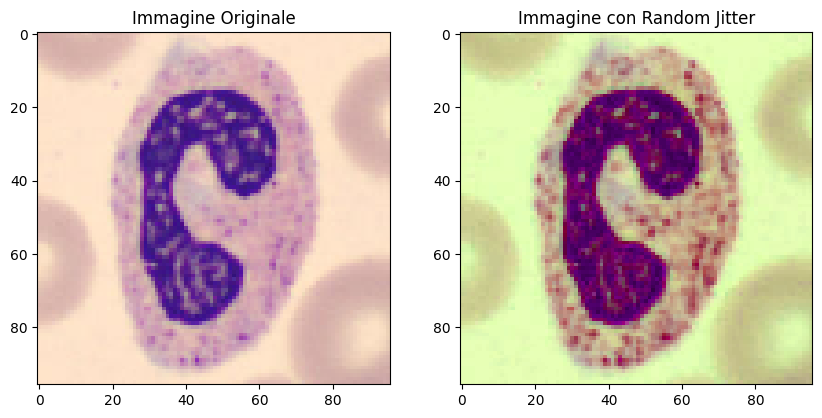

In [ ]:
# prompt: prova la funzione random_jitter su un immagine randomica

# Seleziona un'immagine casuale dal dataset
random_image_index = np.random.randint(0, len(images))
image_to_jitter = images[random_image_index]

# Applica la funzione random_jitter all'immagine
jittered_image = apply_random_jitter(image_to_jitter)

# Converti l'immagine in un array NumPy se necessario
jittered_image = jittered_image.numpy()

# Visualizza l'immagine originale e l'immagine modificata
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_to_jitter.astype(np.uint8))
plt.title("Immagine Originale")

plt.subplot(1, 2, 2)
plt.imshow(jittered_image.astype(np.uint8))
plt.title("Immagine con Random Jitter")

plt.show()

In [ ]:
# Definisci le funzioni di augmentation da usare
augment_functions = [apply_random_jitter, apply_cutout, apply_grid_mask, apply_split_and_rotate]

# Definisci la directory di output per i dati aumentati e bilanciati
output_directory = 'Challenge1/Datasets/Batches_train'

target_size_per_class=5000

# Applica l'augmentation statica e il bilanciamento
static_augmentation_and_balance(x_train, y_train, output_directory, target_size_per_class, augment_functions, batch_size=5000)

Classe 0 salvato in Challenge1/Datasets/Batches_train/augmented_batch_0.npz
Classe 1 salvato in Challenge1/Datasets/Batches_train/augmented_batch_1.npz
Classe 2 salvato in Challenge1/Datasets/Batches_train/augmented_batch_2.npz
Classe 3 salvato in Challenge1/Datasets/Batches_train/augmented_batch_3.npz
Classe 4 salvato in Challenge1/Datasets/Batches_train/augmented_batch_4.npz
Classe 5 salvato in Challenge1/Datasets/Batches_train/augmented_batch_5.npz
Classe 6 salvato in Challenge1/Datasets/Batches_train/augmented_batch_6.npz
Classe 7 salvato in Challenge1/Datasets/Batches_train/augmented_batch_7.npz
Processo completato. I dati sono stati salvati in Challenge1/Datasets/Batches_train.


In [ ]:
# Definisci la directory di output per i dati aumentati e bilanciati
output_directory_train = 'Challenge1/Datasets/Batches_test'
output_directory_val = 'Challenge1/Datasets/Batches_val'

target_size_per_class_train = 500
target_size_per_class_val = 500


# Applica l'augmentation statica e il bilanciamento per il train
static_augmentation_and_balance(x_val, y_val, output_directory_train, target_size_per_class_train, augment_functions, batch_size=5000)

# Applica l'augmentation statica e il bilanciamento per la validation
static_augmentation_and_balance(x_test, y_test, output_directory_val, target_size_per_class_val, augment_functions, batch_size=5000)

Classe 0 salvato in Challenge1/Datasets/Batches_test/augmented_batch_0.npz
Classe 1 salvato in Challenge1/Datasets/Batches_test/augmented_batch_1.npz
Classe 2 salvato in Challenge1/Datasets/Batches_test/augmented_batch_2.npz
Classe 3 salvato in Challenge1/Datasets/Batches_test/augmented_batch_3.npz
Classe 4 salvato in Challenge1/Datasets/Batches_test/augmented_batch_4.npz
Classe 5 salvato in Challenge1/Datasets/Batches_test/augmented_batch_5.npz
Classe 6 salvato in Challenge1/Datasets/Batches_test/augmented_batch_6.npz
Classe 7 salvato in Challenge1/Datasets/Batches_test/augmented_batch_7.npz
Processo completato. I dati sono stati salvati in Challenge1/Datasets/Batches_test.
Classe 0 salvato in Challenge1/Datasets/Batches_val/augmented_batch_0.npz
Classe 1 salvato in Challenge1/Datasets/Batches_val/augmented_batch_1.npz
Classe 2 salvato in Challenge1/Datasets/Batches_val/augmented_batch_2.npz
Classe 3 salvato in Challenge1/Datasets/Batches_val/augmented_batch_3.npz
Classe 4 salvato in 

(500, 96, 96, 3)
(500, 1)


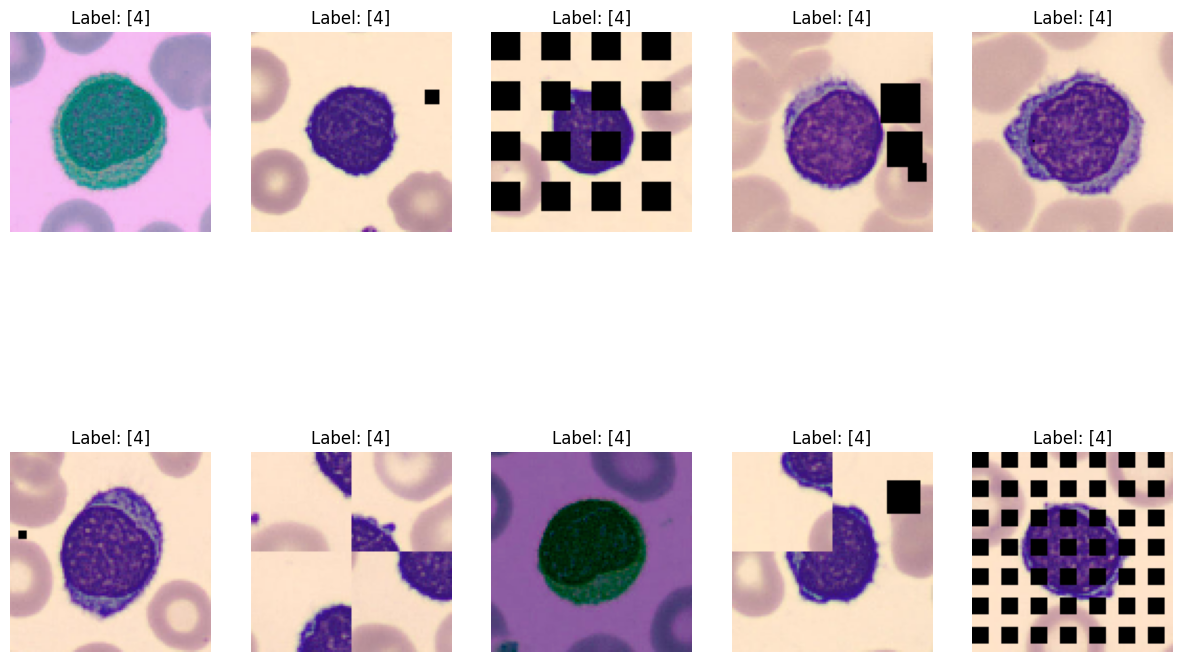

In [ ]:
# prompt: prendi un batch a caso e mostrami 10 immagini casuali

import os
import numpy as np
import matplotlib.pyplot as plt
import random

output_directory = "Challenge1/Datasets/Batches_val"
batch_files = [f for f in os.listdir(output_directory) if f.startswith('augmented_batch_')]

# Seleziona un batch a caso
if batch_files:
  random_batch_file = random.choice(batch_files)
  batch_path = os.path.join(output_directory, random_batch_file)

  data = np.load(batch_path, allow_pickle=True)
  batch_images = data["images"]
  batch_labels = data["labels"]

  print (batch_images.shape)
  print (batch_labels.shape)

  # Mostra 10 immagini casuali dal batch
  num_images_to_show = 10
  random_indices = random.sample(range(len(batch_images)), min(num_images_to_show, len(batch_images)))

  plt.figure(figsize=(15, 10))
  for i, idx in enumerate(random_indices):
      plt.subplot(2, 5, i + 1)
      plt.imshow(batch_images[idx].astype(np.uint8))
      plt.title(f"Label: {batch_labels[idx]}")
      plt.axis('off')

  plt.show()
else:
  print("Nessun batch di immagini trovato nella directory specificata.")

In [ ]:
# prompt: trova tutti i batch creati precedentementi ed esportali come uno unico, considerando i limiti di ram di collab

import numpy as np
import os
import gc
import shutil

output_directory = "Challenge1/Datasets/Batches"
batch_files = [f for f in os.listdir(output_directory) if f.startswith('augmented_batch_')]

all_images = []
all_labels = []

for batch_file in batch_files:
    batch_path = os.path.join(output_directory, batch_file)
    try:
        data = np.load(batch_path, allow_pickle=True)
        batch_images = data["images"]
        batch_labels = data["labels"]

        all_images.extend(batch_images)
        all_labels.extend(batch_labels)

        del data, batch_images, batch_labels
        gc.collect()

    except Exception as e:
        print(f"Errore durante il caricamento del file {batch_file}: {e}")

# Salva tutte le immagini e le etichette in un singolo file npz
if all_images:
    combined_path = os.path.join(output_directory, 'combined_dataset.npz')
    np.savez_compressed(combined_path, images=np.array(all_images), labels=np.array(all_labels))
    print(f"Dataset combinato salvato in {combined_path}")
else:
    print("Nessun batch di immagini trovato o errore durante il caricamento dei batch.")

In [ ]:
def red_transform(image) :
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Convert the image to the HSV color space
  hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

  # Define lower and upper bounds for the violet color (softer threshold)
  lower_violet = np.array([120, 5, 50])   # Adjusted to include more subtle violet tones
  upper_violet = np.array([210, 215, 180])

  # Create a mask for the violet color
  mask = cv2.inRange(hsv_image, lower_violet, upper_violet)

  # Apply Gaussian blur to smooth the mask edges
  mask = cv2.GaussianBlur(mask, (7, 7), 0)

  # Define a smaller kernel for morphological operations to avoid over-expansion
  small_kernel = np.ones((5, 5), np.uint8)  # Smaller kernel for dilation

  # Apply erosion and dilation with fewer iterations
  mask = cv2.erode(mask, small_kernel, iterations=1)  # Erode once
  mask = cv2.dilate(mask, small_kernel, iterations=3)  # Dilate a bit more, but not too much

  # Find contours in the mask
  contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Select the largest contour, assuming it's the main cell
  if contours:
      largest_contour = max(contours, key=cv2.contourArea)
      # Create a new mask with only the largest contour
      cell_mask = np.zeros_like(mask)
      cv2.drawContours(cell_mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

      # Apply the mask to the original image to isolate the main cell
      isolated_cell = cv2.bitwise_and(image_rgb, image_rgb, mask=cell_mask)

      # Convert masked area outside the main cell to white
      output_image = isolated_cell.copy()
      output_image[cell_mask == 0] = [255, 255, 255]

      return output_image



def red_transform_tf(image):
    # Reformat from batch to image
    image_np = image[0, ...]
    transformed_image_np = red_transform(image_np)
    return transformed_image_np[np.newaxis, ...]

red_layer = tf.keras.layers.Lambda(lambda x: tf.numpy_function(
    red_transform_tf, [x], tf.float32))

In [ ]:
def cutmix(image_batch, label_batch, alpha=1.0):
    """Applies CutMix augmentation to a batch of images and labels.

    Args:
        image_batch: A tensor of shape (batch_size, height, width, channels) representing the image batch.
        label_batch: A tensor of shape (batch_size, num_classes) representing the one-hot encoded labels.
        alpha: The CutMix hyperparameter controlling the size of the cutout.

    Returns:
        A tuple containing the mixed images and labels: (mixed_images, mixed_labels).
    """

    batch_size = tf.shape(image_batch)[0]
    image_size = tf.shape(image_batch)[1]

    # Sample lambda from a Beta distribution
    lambda_values = tf.random.uniform([batch_size], 0, 1)

    # Determine the indices of images to mix
    index = tf.random.shuffle(tf.range(batch_size))

    # Calculate the bounding box coordinates
    cutout_center_x = tf.random.uniform([batch_size], 0, image_size, dtype=tf.int32)
    cutout_center_y = tf.random.uniform([batch_size], 0, image_size, dtype=tf.int32)

    cutout_width = tf.cast(tf.math.sqrt(1 - lambda_values) * image_size, dtype=tf.int32)
    cutout_height = tf.cast(tf.math.sqrt(1 - lambda_values) * image_size, dtype=tf.int32)

    # Calculate the bounding box corners
    x1 = tf.clip_by_value(cutout_center_x - cutout_width // 2, 0, image_size)
    y1 = tf.clip_by_value(cutout_center_y - cutout_height // 2, 0, image_size)
    x2 = tf.clip_by_value(cutout_center_x + cutout_width // 2, 0, image_size)
    y2 = tf.clip_by_value(cutout_center_y + cutout_height // 2, 0, image_size)

    # Create the mask
    mask = tf.ones_like(image_batch, dtype=tf.float32)
    for i in range(batch_size):
        mask = tf.tensor_scatter_nd_update(mask, [[i, y1[i]:y2[i], x1[i]:x2[i], :]], tf.zeros([y2[i] - y1[i], x2[i] - x1[i], 3]))

    # Apply CutMix to images
    mixed_images = image_batch * mask + tf.gather(image_batch, index) * (1 - mask)

    # Adjust lambda to account for the area of the cutout
    lambda_values = tf.cast(cutout_width * cutout_height, dtype=tf.float32) / (image_size * image_size)

    # Apply CutMix to labels
    mixed_labels = lambda_values[:, None] * label_batch + (1 - lambda_values[:, None]) * tf.gather(label_batch, index)

    return mixed_images, mixed_labels

In [ ]:
import tensorflow as tf
import numpy as np

class MixUpLayer(tf.keras.layers.Layer):
    def __init__(self, alpha=0.2):
        super(MixUpLayer, self).__init__()
        self.alpha = alpha

    def call(self, inputs, training=False):
        # Estrai le immagini e le etichette
        images, labels = inputs

        # Calcola un lambda casuale
        lambda_value = np.random.beta(self.alpha, self.alpha)

        # Se la modalità è training, applica MixUp
        if training:
            # Mescola le immagini
            batch_size = tf.shape(images)[0]
            indices = tf.random.shuffle(tf.range(batch_size))
            mixed_images = lambda_value * images + (1 - lambda_value) * tf.gather(images, indices)

            # Mescola le etichette
            mixed_labels = lambda_value * labels + (1 - lambda_value) * tf.gather(labels, indices)
        else:
            # In modalità di inferenza, non applicare MixUp
            mixed_images = images
            mixed_labels = labels

        return mixed_images, mixed_labels


# Funzione per applicare il MixUp
def apply_mixup(images, labels, alpha=0.2):
    mixup_layer = MixUpLayer(alpha)
    mixed_images, mixed_labels = mixup_layer((images, labels), training=True)

    return mixed_images, mixed_labels

mixup_layer = MixUpLayer(alpha=0.2)

In [ ]:
# prompt: crea un layer come quelli gia presenti che faccia un random mask grid

class RandomMaskGrid(tfkl.Layer):
  def __init__(self, mask_ratio=0.2, **kwargs):
    super(RandomMaskGrid, self).__init__(**kwargs)
    self.mask_ratio = mask_ratio

  def call(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size = input_shape[0]
    height = input_shape[1]
    width = input_shape[2]

    # Generate random grid size
    grid_size = tf.cast(tf.sqrt(tf.cast(height * width * self.mask_ratio, tf.float32)), tf.int32)
    grid_size = tf.maximum(grid_size, 1)  # Ensure at least one grid cell is masked

    # Generate random starting points for grid cells
    start_row = tf.random.uniform(shape=(batch_size,), minval=0, maxval=height - grid_size, dtype=tf.int32)
    start_col = tf.random.uniform(shape=(batch_size,), minval=0, maxval=width - grid_size, dtype=tf.int32)

    # Create masks for each image in the batch
    masks = []
    for i in range(batch_size):
      mask = tf.ones((height, width, 1), dtype=tf.float32)
      mask = tf.tensor_scatter_nd_update(
          mask,
          tf.stack([
              tf.range(start_row[i], start_row[i] + grid_size),
              tf.range(start_col[i], start_col[i] + grid_size),
              tf.zeros((grid_size,), dtype=tf.int32)
          ], axis=1),
          tf.zeros((grid_size, grid_size, 1), dtype=tf.float32)
      )
      masks.append(mask)
    masks = tf.stack(masks)

    # Apply the mask to the input image (example: setting masked pixels to 0)
    masked_inputs = inputs * masks
    return masked_inputs

# Example usage
random_mask_grid_layer = RandomMaskGrid(mask_ratio=0.2)


In [ ]:
height = width = 96

augment_model_1 = tf.keras.Sequential([
    red_layer
])

augment_model_2 = tf.keras.Sequential([
    cutmix_layer
])

augment_model_3 = tf.keras.Sequential([
    mixup_layer
])

augment_model_4 = tf.keras.Sequential([
    random_mask_grid_layer
])

augment_models = [augment_model_1, augment_model_2, augment_model_3, augment_model_4]

In [ ]:
# Optimize image augmentation to stay beneath colab ram limits
def batch_augment_images_to_target(images, labels, augment_models, target_size, batch_size, output_dir):
    # Calculate initial class distribution
    unique, counts = np.unique(labels, return_counts=True)
    class_distribution = dict(zip(unique, counts))

    # Determine additional images needed to reach target size while maintaining distribution
    additional_images_needed = target_size - len(images)
    additional_per_class = {label: additional_images_needed // len(unique) for label in unique}

    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Containers for augmented images and labels
    augmented_images = []
    augmented_labels = []

    # Batch augmentation loop
    batch_counter = 0
    while sum(additional_per_class.values()) > 0:
        # Loop through each image and label
        for img, label in zip(images, labels):
            if additional_per_class[label] > 0:
                # Randomly select an augmentation model and apply it
                model = np.random.choice(augment_models)
                augmented_img = model(img[np.newaxis, ...], training=True).numpy()[0]

                # Append the augmented image and label
                augmented_images.append(augmented_img)
                augmented_labels.append(label)

                # Decrement the count for the class
                additional_per_class[label] -= 1

                # If we've built up a full batch, save and clear the batch
                if len(augmented_images) == batch_size:
                    batch_path = os.path.join(output_dir, f'augmented_batch_{batch_counter}.npz')
                    np.savez(batch_path, data=np.array(augmented_images), labels=np.array(augmented_labels))
                    print(f"Batch {batch_counter} saved to {batch_path}")  # Debug print
                    augmented_images = []
                    augmented_labels = []
                    batch_counter += 1
                    gc.collect()  # Collect garbage to free memory

        # Shuffle the original dataset for the next pass
        indices = np.arange(len(images))
        np.random.shuffle(indices)
        images = images[indices]
        labels = labels[indices]

    # Save any remaining images that didn't make up a full batch
    if augmented_images:
        batch_path = os.path.join(output_dir, f'augmented_batch_{batch_counter}.npz')
        np.savez(batch_path, data=np.array(augmented_images), labels=np.array(augmented_labels))
        print(f"Batch {batch_counter} saved to {batch_path}")  # Debug print
        gc.collect()  # Collect garbage to free memory